# Main Code

In [ ]:
import numpy as np
from numpy import array
import cv2
from PIL import Image
import scipy.linalg
from matplotlib.image import imread
import matplotlib.pyplot as plt
from scipy.linalg import svd 
import timeit

In [ ]:
matr = []
for l in range(1,31):
    name = str(l)+".jpg"
    im = Image.open(name)
    resize = (50,50)
    im1 = im.resize(resize)
    arr = array(im1)
    ls = []
    for i in range(50):
        for j in range(50):
            for k in range(3):
                ls = ls + [arr[i][j][k]]

    matr = matr + [ls]
    ls = []

matrix = array(matr)

In [ ]:
mat = np.transpose(matrix)

In [ ]:
## Algorithm
import numpy.linalg as la
def new_svd(U,S,V,Ai):
    #function to find SVD of B_{i+1}
    UT = np.transpose(U)
    # Finding projection of Ai in U space
    
    ## STEP 1

    x = np.dot(UT,Ai)    
    # Finding projection of Ai perpendicular to U space. no scaling is required as U are normalized
     
    ## STEP 2

    a_p = Ai - np.dot(U,x)
    
    # normalizing it
    if (la.norm(a_p) > 0.5):
        a_p = a_p/(la.norm(a_p))
        z = np.dot(np.transpose(a_p),Ai)
    else:
        z = np.array([[0]])

    ##STEP 3

    # creating broken arrow matrix, so we need to create diagonal matrix from S(sigma values)
    sigma_i = np.diag(S)
    # we need a 0 vector for the last row of broken arrow matrix of the same length as S
    ze = np.zeros((1,len(S)))
    # stacking x as column to Sigma_i
    sh = np.hstack((sigma_i,x))
    
    # stacking a_p*Ai to zerovector
    ze1 = np.hstack((ze,z))
    # now doing vertical stack of these two to get brokec arrow matrix
    new_B = np.vstack((sh,ze1))
    
    # now find the SVD of this broken arrow matrix
    W, lam, QT = la.svd(new_B)
    
    ## STEP 4
    Q = np.transpose(QT)
    # now we need to find new U, sigma and V
    Uk = np.hstack((U,a_p))
    # new U is
    new_U = np.dot(Uk,W)
    
    ## STEP 5
    # For new V, we need to create new 0 column and 0 row
    ze_col = np.zeros((len(V),1))
    ze_row = np.zeros((1,len(np.transpose(V))))

    v_h = np.hstack((V,ze_col))
    
    mod_V = np.vstack((v_h,np.hstack((ze_row,np.ones((1,1)))))) 
    # new V
    
    new_V = np.dot(mod_V,Q)
    

    ## STEP 6
    # new sigma
    new_S = lam
    
    return(new_U, new_S,new_V)



In [ ]:
def eigenspace_update(B,ep):
    # This function decides how much information to keep and how much to discard 
    # first we need to find number of images in matrix B, which equals number of columns of B
    num = np.shape(B)[1]   # NO of columns
    
    # first image is first column of B
    A1 = B[:,0]
    # but it is in form of row so we need to convert it in the form of column
    A1 = np.reshape(A1,(len(A1),1))
    # U1 is just normalised vector of A1
    U1 = A1/la.norm(A1)
    V1 = np.ones((1,1))
    S1 = [la.norm(A1)]
    

    for i in range(1,num):
        Ai = B[:,i]
        
        A = np.reshape(Ai,(len(Ai),1))
        U_next, S_next, V_next = new_svd(U1,S1,V1,A)
        


        for j in range(len(S_next)):
            Uj = U_next[:,:j+1]
            
            Sj = S_next[:j+1]
            Sj = np.diag(Sj)
            
            Vj = V_next[:,:j+1]
            b_pr = np.dot(Uj,Sj)
            
            Bj = np.dot(b_pr,np.transpose(Vj))
            # This is stopping criteria ;

            if la.norm(B[:,:i+1]-Bj) < ep:       
                break
        U1 = U_next[:,:j+1]
        S1 = S_next[:j+1]
        V1 = V_next[:,:j+1]
        
    return(U1,S1,V1)

# Time difference

In [ ]:
U,S,VT = svd(mat)
start = timeit.default_timer()
for i in range(1,31):
    U,S,VT = svd(mat[:,:i])
stop = timeit.default_timer()
print(stop-start)

11.480097370000294


In [ ]:
start = timeit.default_timer()
U,sigma,V = eigenspace_update(mat,5000)
stop = timeit.default_timer()
print(stop-start)

0.6361492740034009


# Implementation

In [ ]:
def img_cmp(im1,ep):
  image_array = np.array(im1)
  image_array = image_array.flatten()
  image_array = image_array.reshape((100,300))
  image_array = np.transpose(image_array)
  u_matrix, sigma_mat, V_mat = eigenspace_update(image_array,ep)

  k_mat = np.dot(u_matrix,np.diag(sigma_mat))
  g_mat = np.dot(k_mat, np.transpose(V_mat))


  image_out = np.transpose(g_mat)
  image_out = image_out.flatten()
  image_out = image_out.astype('uint8')
  image_out = image_out.reshape((100,100,3))
  image_final = Image.fromarray(image_out,"RGB")
  plt.imshow(image_final)
  return plt.show()


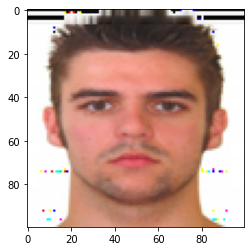

In [ ]:
im = Image.open("test.jpg")
resize = (100,100)
im1 = im.resize(resize)
k= 1000
img_cmp(im1,k)



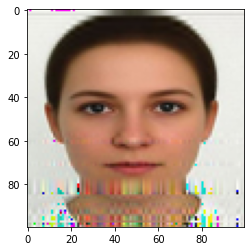

In [ ]:
im = Image.open("test3.jpg")
resize = (100,100)
im1 = im.resize(resize)
k= 1000
img_cmp(im1,k)

#Comparison


In [ ]:
#function for comparison on different epsilons.
def img_cmp1(im1,ep, ep1, ep2):
  image_array = np.array(im1)
  image_array = image_array.flatten()
  image_array = image_array.reshape((100,300))
  image_array = np.transpose(image_array)

  u_1, sigma_1, V_1 = eigenspace_update(image_array,ep)
  k_1 = np.dot(u_1,np.diag(sigma_1))
  g_1 = np.dot(k_1, np.transpose(V_1))

  u_2, sigma_2, V_2 = eigenspace_update(image_array,ep1)
  k_2 = np.dot(u_2,np.diag(sigma_2))
  g_2 = np.dot(k_2, np.transpose(V_2))

  u_3, sigma_3, V_3 = eigenspace_update(image_array,ep2)
  k_3 = np.dot(u_3,np.diag(sigma_3))
  g_3 = np.dot(k_3, np.transpose(V_3))

  image_out1 = np.transpose(g_1)
  image_out1 = image_out1.flatten()
  image_out1 = image_out1.astype('uint8')
  image_out1 = image_out1.reshape((100,100,3))
  image_1 = Image.fromarray(image_out1,"RGB")

  image_out2 = np.transpose(g_2)
  image_out2 = image_out2.flatten()
  image_out2 = image_out2.astype('uint8')
  image_out2 = image_out2.reshape((100,100,3))
  image_2 = Image.fromarray(image_out2,"RGB")

  image_out3 = np.transpose(g_3)
  image_out3 = image_out3.flatten()
  image_out3 = image_out3.astype('uint8')
  image_out3 = image_out3.reshape((100,100,3))
  image_3 = Image.fromarray(image_out3,"RGB")


  fig = plt.figure()
  ax1 = fig.add_subplot(1,3,1)
  ax1.imshow(image_1)
  ax2 = fig.add_subplot(1,3,2)
  ax2.imshow(image_2)
  ax3 = fig.add_subplot(1,3,3)
  ax3.imshow(image_3)

  #plt.imshow(image_final)
  return plt.show()


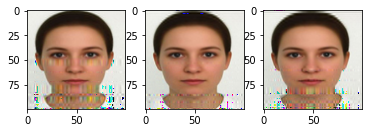

In [ ]:
img_cmp1(im1,100,500,1000)

#Error and Time Analysis


---



*  It shows how much error we get on choosing an epsilon




In [ ]:
def error(im1,ep):
  image_array = np.array(im1)
  image_array = image_array.flatten()
  image_array = image_array.reshape((100,300))
  image_array = np.transpose(image_array)
  u_matrix, sigma_mat, V_mat = eigenspace_update(image_array,ep)

  k_mat = np.dot(u_matrix,np.diag(sigma_mat))
  g_mat = np.dot(k_mat, np.transpose(V_mat))
  return la.norm(image_array - g_mat)

In [ ]:
x_e = [100, 500, 1000, 2000,3000, 4000,5000,7000,8000,10000]
y_e = []
im = Image.open("11.jpg")
resize = (100,100)
im1 = im.resize(resize)
for i in x_e:
  y_e.append(error(im1, i))

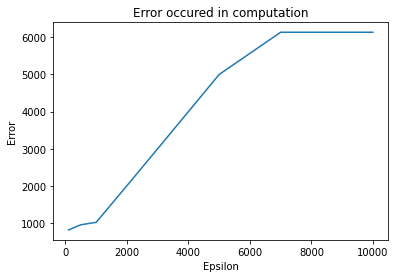

In [ ]:
plt.plot(x_e,y_e)
plt.title('Error occured in computation')
plt.xlabel('Epsilon')
plt.ylabel('Error')
plt.show()

Relation between epsilon and time taken to compute for that epsilon

In [ ]:
def time(mat,ep):
  start = timeit.default_timer()
  U,sigma,V = eigenspace_update(mat,ep)
  stop = timeit.default_timer()
  k = stop-start
  return k

In [ ]:
start = timeit.default_timer()
U,sigma,V = eigenspace_update(mat,50000)
stop = timeit.default_timer()
print(stop-start)

0.047264927001378965


In [ ]:
x_t = [100, 500, 1000, 2000, 3000,4000,6000,10000]
y_t = []
for i in x_t:
  y_t.append(time(mat, i))

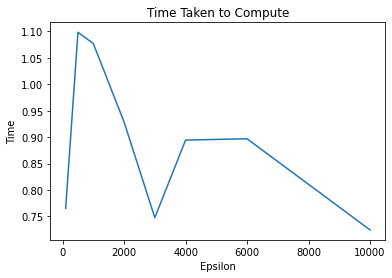

In [ ]:
plt.plot(x_t,y_t)
plt.title('Time Taken to Compute')
plt.xlabel('Epsilon')
plt.ylabel('Time')
plt.show()